<a href="https://colab.research.google.com/github/gloriapintado/Cervical-Cancer-Prediction/blob/main/Cervical_Cancer_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling with VGG16

The VGG16 neural network, extensively pretrained on diverse image datasets for classification, offers the advantage of improved accuracy in image recognition.

## Importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image, ImageOps
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and processing images from dataset

In [4]:
image_directory = '/content/drive/MyDrive/Cervical Cancer/'
SIZE = 150

dataset = []
label = []

# For each class, load images and assign labels
class_folders = ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']

for class_folder in class_folders:
    images = os.listdir(image_directory + class_folder + '/')
    for image_name in images:
        if image_name.split('.')[1] == 'jpg':
            image = cv2.imread(image_directory + class_folder + '/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))

            label.append(class_folders.index(class_folder))

dataset = np.array(dataset)
label = np.array(label)

## Split the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 42)

In [28]:
# See shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20000, 150, 150, 3)
X_test shape: (5000, 150, 150, 3)
y_train shape: (20000,)
y_test shape: (5000,)


# Pretrained VGG16 Model

In [7]:
# Download the VGG16 base
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [8]:
VGG16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

###  My classifier

In [9]:
# Do a basic classifier and add the downloaded VGG16 base to it
vgg16_model = Sequential()
vgg16_model.add(VGG16_base)
vgg16_model.add(Lambda(lambda x: x / 255.0))
vgg16_model.add(Flatten())
vgg16_model.add(Dense(256, activation='relu'))
vgg16_model.add(Dense(5, activation='softmax'))

In [10]:
# pre-trained weights are all frozen
VGG16_base.trainable = False

In [11]:
# Create a callback and compile the VGG16_model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
vgg16_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizers.RMSprop(learning_rate=2e-5),
                 metrics=['accuracy'])

In [12]:
history_vgg16_model = vgg16_model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[early_stopping], batch_size=32)

Epoch 1/15
625/625 [==============================] - 26s 28ms/step - loss: 1.3588 - accuracy: 0.6534 - val_loss: 1.1096 - val_accuracy: 0.8100
Epoch 2/15
625/625 [==============================] - 16s 26ms/step - loss: 0.9438 - accuracy: 0.8335 - val_loss: 0.8087 - val_accuracy: 0.8490
Epoch 3/15
625/625 [==============================] - 16s 26ms/step - loss: 0.7165 - accuracy: 0.8626 - val_loss: 0.6395 - val_accuracy: 0.8648
Epoch 4/15
625/625 [==============================] - 16s 26ms/step - loss: 0.5806 - accuracy: 0.8792 - val_loss: 0.5339 - val_accuracy: 0.8788
Epoch 5/15
625/625 [==============================] - 16s 26ms/step - loss: 0.4912 - accuracy: 0.8923 - val_loss: 0.4607 - val_accuracy: 0.8932
Epoch 6/15
625/625 [==============================] - 16s 26ms/step - loss: 0.4266 - accuracy: 0.9038 - val_loss: 0.4067 - val_accuracy: 0.9054
Epoch 7/15
625/625 [==============================] - 16s 26ms/step - loss: 0.3769 - accuracy: 0.9138 - val_loss: 0.3644 - val_accuracy:

In [13]:
evaluation = vgg16_model.evaluate(X_test, y_test)

157/157 [==============================] - 3s 21ms/step - loss: 0.1942 - accuracy: 0.9546


# Unfreezing first block of VGG16 Base

In [14]:
# unfreezed all layer first for a fine-tune process
VGG16_base.trainable = True

In [15]:
# keep first block unfreezed(trainable) and freeze all other layers
for layer in VGG16_base.layers:
    if layer.name in ['block1_conv1', 'block1_conv2']:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
vgg16_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizers.RMSprop(learning_rate=2e-5),
                 metrics=['accuracy'])

In [17]:
history_vgg16_model_fine = vgg16_model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[early_stopping], batch_size=32)

Epoch 1/15
625/625 [==============================] - 37s 55ms/step - loss: 0.1392 - accuracy: 0.9649 - val_loss: 0.1390 - val_accuracy: 0.9620
Epoch 2/15
625/625 [==============================] - 33s 53ms/step - loss: 0.1101 - accuracy: 0.9712 - val_loss: 0.1186 - val_accuracy: 0.9662
Epoch 3/15
625/625 [==============================] - 33s 54ms/step - loss: 0.0926 - accuracy: 0.9761 - val_loss: 0.1040 - val_accuracy: 0.9728
Epoch 4/15
625/625 [==============================] - 33s 54ms/step - loss: 0.0793 - accuracy: 0.9801 - val_loss: 0.0933 - val_accuracy: 0.9742
Epoch 5/15
625/625 [==============================] - 33s 54ms/step - loss: 0.0687 - accuracy: 0.9834 - val_loss: 0.0813 - val_accuracy: 0.9776
Epoch 6/15
625/625 [==============================] - 34s 54ms/step - loss: 0.0598 - accuracy: 0.9865 - val_loss: 0.0732 - val_accuracy: 0.9804
Epoch 7/15
625/625 [==============================] - 34s 54ms/step - loss: 0.0525 - accuracy: 0.9884 - val_loss: 0.0661 - val_accuracy:

### Saving Best Model

In [19]:
vgg16_model_save_name = 'vgg16_model.h5'
vgg16_model.save(vgg16_model_save_name)

drive_path = "/content/drive/MyDrive/Cervical_Cancer_Models/models/"

vgg16_model_save_save_path = os.path.join(drive_path, vgg16_model_save_name)
vgg16_model.save(vgg16_model_save_save_path)

# Evaluating Best Model

In [20]:
predictions2 = vgg16_model.predict(X_test)

157/157 [==============================] - 3s 20ms/step


In [21]:
y_pred2 = np.argmax(predictions2, axis=1)

## Accuracy and loss of the Best model

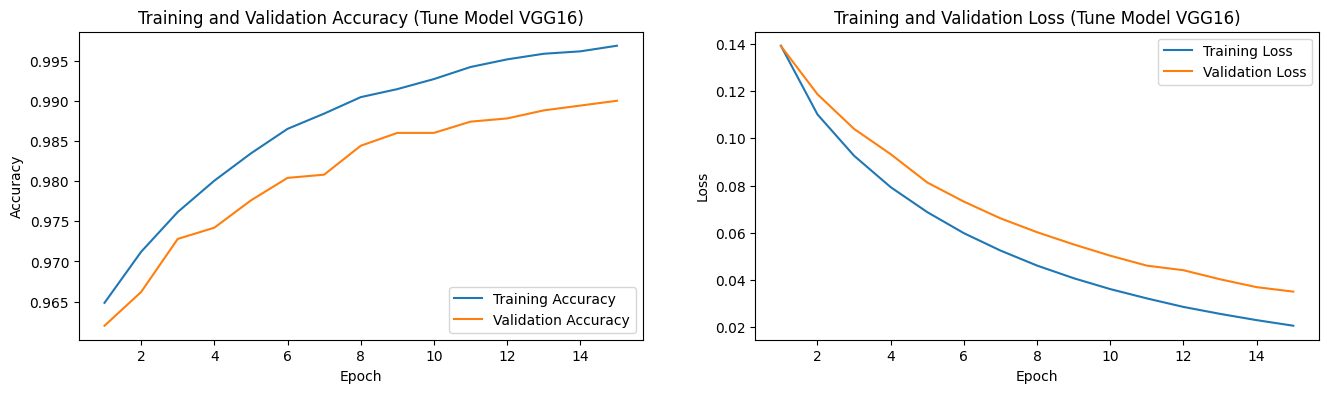

In [23]:
acc = history_vgg16_model_fine.history['accuracy']
val_acc = history_vgg16_model_fine.history['val_accuracy']
loss = history_vgg16_model_fine.history['loss']
val_loss = history_vgg16_model_fine.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Tune Model VGG16)')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Tune Model VGG16)')
plt.show()

## Best Model Confusion Matrix

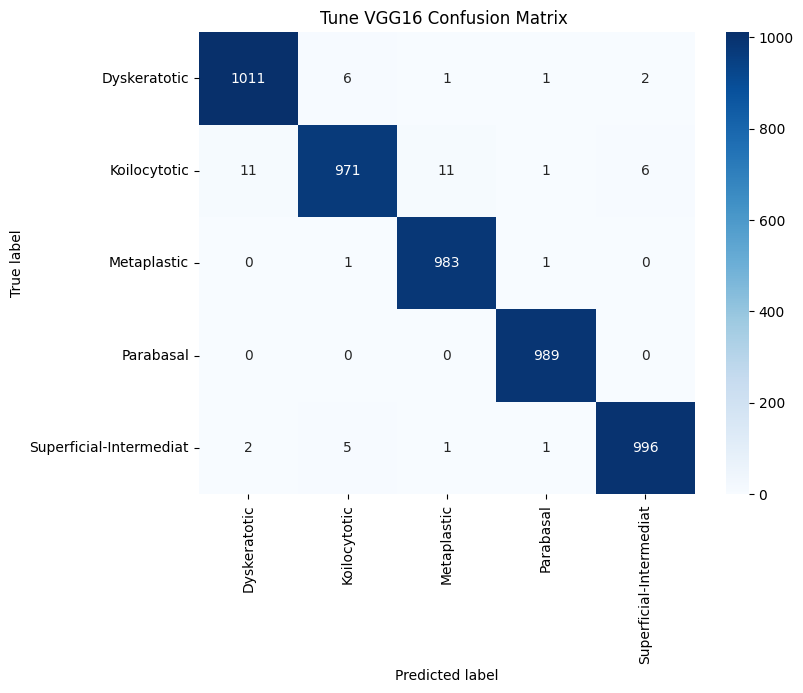

In [24]:
class_names = ['Dyskeratotic','Koilocytotic','Metaplastic','Parabasal','Superficial-Intermediat']

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Tune VGG16 Confusion Matrix ')
plt.show()

In [25]:
class_names = ['Dyskeratotic','Koilocytotic','Metaplastic','Parabasal','Superficial-Intermediat']

In [26]:
print(classification_report(y_test, y_pred2, target_names=class_names))

                         precision    recall  f1-score   support

           Dyskeratotic       0.99      0.99      0.99      1021
           Koilocytotic       0.99      0.97      0.98      1000
            Metaplastic       0.99      1.00      0.99       985
              Parabasal       1.00      1.00      1.00       989
Superficial-Intermediat       0.99      0.99      0.99      1005

               accuracy                           0.99      5000
              macro avg       0.99      0.99      0.99      5000
           weighted avg       0.99      0.99      0.99      5000



## Display true values and predicted values

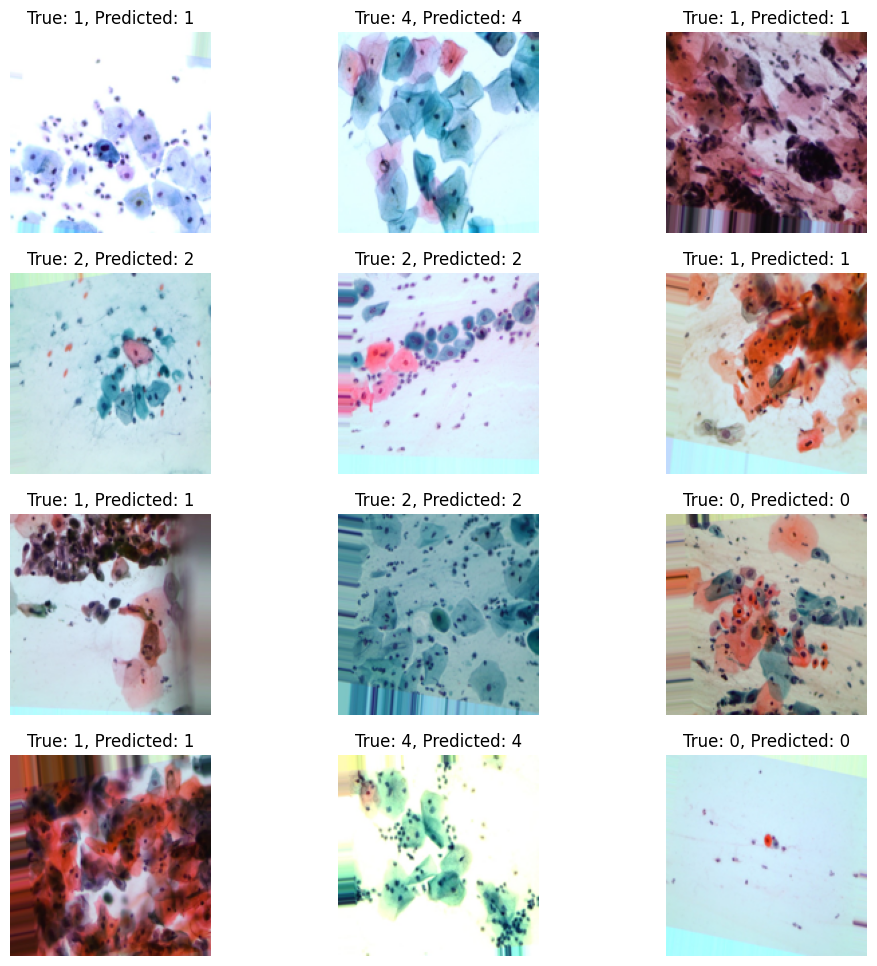

In [27]:
plt.figure(figsize=(12, 12))

for i in range(12):
    # Display the image in RGB format
    image_rgb = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB)

    plt.subplot(4, 3, i + 1)
    plt.imshow(image_rgb)
    plt.title(f"True: {y_test[i]}, Predicted: {y_pred2[i]}")
    plt.axis('off')

plt.show()

## Recall for best model

After the accuracy metric being important, the recall metric is also really important since considering the importance of minimizing false negatives. In the context of medical applications, such as the detection of diseases like cervical cancer, false negatives can have serious issue.

Recall scores for Best Model Overall

Dyskeratotic: 99% \
Koilocytotic: 97% \
Metaplastic: 99% \
Parabasal: 100% \
Superficial-Intermediat: 100%
- The improvements in recall for Dyskeratotic, Metaplastic, Parabasal, and Superficial-Intermediate categories suggest that the fine-tuning of the VGG16 model has enhanced the model's performance in recognizing these classes.

# Recommendations

- Implement an automated tool, based on the fine-tuned VGG16 model, in neighborhood clinics across Africa. To enhance the identification and referral process for possible instances of cervical cancer, contributing to quicker and more precise diagnoses.
- Promote Public Awareness by conducting awareness campaigns to inform communities about screening centers, emphasizing early detection benefits.


# Next Steps

- Explore Various Transfer Learning Models
- Add more types of cancer, for model to learn to distinguish between different types of cancer.
